#  Building a Classifier (Titanic)
**Author:** Dinesh Gurumoorthy   
**Date:** November 7, 2025  
**Objective:** Project 3 Titanic Dataset - Predicting a Categorical Target and Evaluating Performance.

- Decision Tree Classifier (DT) - A Decision Tree splits data into smaller groups based on decision rules (like "is height greater than 150 cm.
  - Decision Trees illustrate how individual features contribute to classification.
- Support Vector Machine (SVM) - A Support Vector Machine tries to find the "best boundary" (a hyperplane) that separates data into classes. 
  - SVMs are good at finding complex boundaries.
- Neural Network (NN) - A Neural Network is inspired by how human brains process information. 
  - Neural Networks are good at learning patterns from complex data.

## Section 1.  Import and Inspect the Data

In [43]:
# all imports at the top, organized
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix
from matplotlib.colors import ListedColormap

In [44]:
# Load Titanic dataset
titanic = sns.load_dataset('titanic')
# Display a few records to verify
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


## Section 2. Data Exploration and Preparation

### 2.1 Handle Missing Values and Clean Data

Impute missing values for age using the median:

In [45]:
median_age = titanic['age'].median()
titanic['age'] = titanic['age'].fillna(median_age)

# Fill in missing values for embark_town using the mode:
mode_embark = titanic['embark_town'].mode()[0]
titanic['embark_town'] = titanic['embark_town'].fillna(mode_embark)

### 2.2 Feature Engineering

Create any new features that might be helpful for the model from the existing data. This is not making up new data - it is providing existing data in a more helpful, concise way for modeling.

In this case, we want to add a calculated feature we'll call family_size.

Create new features:

    Add family_size - number of family members on board. Count sibsp (number of siblings or spouses on board), parch (number of parents or children on board), and 1 to count the individual. 

Most ML models need numerical input, even for the categories. We do this by mapping categorical variables to numbers. There  is no set way to do this - we'll show one example mapping for each of these below. 

    Convert categorical "sex" (male/female) to numeric binary (0 or 1)
        male =0, female=1
    Convert categorical "embarked" to numeric
        "C" (Cherboug) = 0
        "Q" (Queenstown) = 1
        "S" (Southampton) = 2
    Binary feature - convert "alone" to numeric binary (0 or 1)
        alone = 1, 0 = not alone



In [46]:
# Create new feature
titanic['family_size'] = titanic['sibsp'] + titanic['parch'] + 1

# Map categories to numeric values
titanic['sex'] = titanic['sex'].map({'male': 0, 'female': 1})
titanic['embarked'] = titanic['embarked'].map({'C': 0, 'Q': 1, 'S': 2})
titanic['alone'] = titanic['alone'].astype(int)

## Section 3. Feature Selection and Justification
### 3.1 Choose features and target

    Select two or more input features (numerical for regression, numerical and/or categorical for classification)
    Use survived as the target. 
    We will do three input cases like the example. 

Case 1: 

    input features: alone
    target: survived

Case 2:

    input features - age
    target: survived

Case 3:

    input features -  age and family_size 
    target: survived


### 3.2 Define X (features) and y (target)

- Assign input features to X a pandas DataFrame with 1 or more input features
- Assign target variable to y (as applicable) - a pandas Series with a single target feature
- Again - use comments to run a single case at a time
- The follow starts with only the statements needed for case 1. 
- Double brackets [[ ]]  makes a 2D DataFrame
- Single brackets [ ]  make a 1D Series


In [47]:
# Case 1: Feature = alone

# Select the feature 'alone' as input
X1 = titanic[['alone']]

# Select 'survived' as the target for the same rows
y1 = titanic['survived']

In [48]:
# Case 2: Feature = age (drop if na or not available)

# Select the feature 'age', but drop rows where age is missing
X2 = titanic[['age']].dropna()

# Select the matching 'survived' values using the same index
y2 = titanic.loc[X2.index, 'survived']

In [49]:
# Case 3: Features = Age + Family Size (drop if na or not available)

# Select both 'age' and 'family_size', and drop rows where missing (na)
X3 = titanic[['age', 'family_size']].dropna()

# Select the corresponding 'survived' values for those rows
y3 = titanic.loc[X3.index, 'survived']

### Reflection 3:

1. **Why are these features selected?**

   **Case 1 - 'alone':**
   - Simple binary feature that's easy to interpret and visualize and test whether traveling alone vs. with family affected survival decisions and outcomes
  
   **Case 2 - 'age':**
   - Continuous variable provides more granular information than binary features
  
   **Case 3 - 'age + family_size':**
   - Tests whether family size has optimal ranges (small families vs. large families vs. individuals)

2. **Are there features that are likely to be highly predictive of survival?**

   - Yes, Gender and Passenger Class (pclass) will be good predictors of survival.

## Section 4. Train a Classification Model (Decision Tree)
 
### 4.1 Split the Data

Split the data into training and test sets.

First, choose a data splitter. StratifiedShuffleSplit ensures that both training and test sets have a similar proportion of each class (survived = 0 or 1). 

In [50]:
# Case 1: Feature = alone
splitter1 = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=123)
for train_idx1, test_idx1 in splitter1.split(X1, y1):

    X1_train = X1.iloc[train_idx1]
    X1_test  = X1.iloc[test_idx1]
    y1_train = y1.iloc[train_idx1]
    y1_test  = y1.iloc[test_idx1]

print('Case 1 - Alone:')
print('Train size:', len(X1_train), '| Test size:', len(X1_test))

Case 1 - Alone:
Train size: 712 | Test size: 179


In [51]:
# Case 2: Feature = age
splitter2 = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=123)
for train_idx2, test_idx2 in splitter2.split(X2, y2):
    X2_train = X2.iloc[train_idx2]
    X2_test  = X2.iloc[test_idx2]
    y2_train = y2.iloc[train_idx2]
    y2_test  = y2.iloc[test_idx2]

print('Case 2 - Age:')
print('Train size:', len(X2_train), '| Test size:', len(X2_test))

Case 2 - Age:
Train size: 712 | Test size: 179


In [52]:
# Case 3: Features = age + family_size
splitter3 = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=123)
for train_idx3, test_idx3 in splitter3.split(X3, y3):
    X3_train = X3.iloc[train_idx3]
    X3_test  = X3.iloc[test_idx3]
    y3_train = y3.iloc[train_idx3]
    y3_test  = y3.iloc[test_idx3]

print('Case 3 - Age + Family Size:')
print('Train size:', len(X3_train), '| Test size:', len(X3_test))

Case 3 - Age + Family Size:
Train size: 712 | Test size: 179


### 4.2 Create and Train Model (Decision Tree)

    Create and train a decision tree model with no random initializer argument.


In [53]:
# CASE 1: Decision Tree using alone
tree_model1 = DecisionTreeClassifier()
tree_model1.fit(X1_train, y1_train)

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [54]:
# CASE 2: Decision Tree using age
tree_model2 = DecisionTreeClassifier()
tree_model2.fit(X2_train, y2_train)

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [55]:
# CASE 3: Decision Tree using age and family_size
tree_model3 = DecisionTreeClassifier()
tree_model3.fit(X3_train, y3_train)

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


### 4.3 Predict and Evaluate Model Performance

Evaluate model performance on training data

In [56]:
# Predict on training data for alone
y1_pred = tree_model1.predict(X1_train)
print("Results for Decision Tree on training data (Case 1 - alone):")
print(classification_report(y1_train, y1_pred))

# Predict on test data
y1_test_pred = tree_model1.predict(X1_test)
print("Results for Decision Tree on test data (Case 1 - alone):")
print(classification_report(y1_test, y1_test_pred))

Results for Decision Tree on training data (Case 1 - alone):
              precision    recall  f1-score   support

           0       0.69      0.69      0.69       439
           1       0.50      0.51      0.51       273

    accuracy                           0.62       712
   macro avg       0.60      0.60      0.60       712
weighted avg       0.62      0.62      0.62       712

Results for Decision Tree on test data (Case 1 - alone):
              precision    recall  f1-score   support

           0       0.71      0.65      0.68       110
           1       0.51      0.58      0.54        69

    accuracy                           0.63       179
   macro avg       0.61      0.62      0.61       179
weighted avg       0.64      0.63      0.63       179



In [57]:
# Predict on training data for age
y2_pred = tree_model2.predict(X2_train)
print("Results for Decision Tree on training data (Case 2 - age):")
print(classification_report(y2_train, y2_pred))

# Predict on test data
y2_test_pred = tree_model2.predict(X2_test)
print("Results for Decision Tree on test data (Case 2 - age):")
print(classification_report(y2_test, y2_test_pred))

Results for Decision Tree on training data (Case 2 - age):
              precision    recall  f1-score   support

           0       0.68      0.92      0.78       439
           1       0.69      0.29      0.41       273

    accuracy                           0.68       712
   macro avg       0.68      0.61      0.60       712
weighted avg       0.68      0.68      0.64       712

Results for Decision Tree on test data (Case 2 - age):
              precision    recall  f1-score   support

           0       0.63      0.89      0.74       110
           1       0.50      0.17      0.26        69

    accuracy                           0.61       179
   macro avg       0.57      0.53      0.50       179
weighted avg       0.58      0.61      0.55       179



In [58]:
# Predict on training data for family size + age
y3_pred = tree_model3.predict(X3_train)
print("Results for Decision Tree on training data (Case 3 - age + family_size):")
print(classification_report(y3_train, y3_pred))

# Predict on test data
y3_test_pred = tree_model3.predict(X3_test)
print("Results for Decision Tree on test data (Case 3 - age + family_size):")
print(classification_report(y3_test, y3_test_pred))

Results for Decision Tree on training data (Case 3 - age + family_size):
              precision    recall  f1-score   support

           0       0.77      0.90      0.83       439
           1       0.77      0.56      0.65       273

    accuracy                           0.77       712
   macro avg       0.77      0.73      0.74       712
weighted avg       0.77      0.77      0.76       712

Results for Decision Tree on test data (Case 3 - age + family_size):
              precision    recall  f1-score   support

           0       0.64      0.75      0.69       110
           1       0.45      0.33      0.38        69

    accuracy                           0.59       179
   macro avg       0.55      0.54      0.54       179
weighted avg       0.57      0.59      0.57       179



### 4.4 Report Confusion Matrix (as a heatmap)

Plot a confusion matrix as a heatmap for all cases:

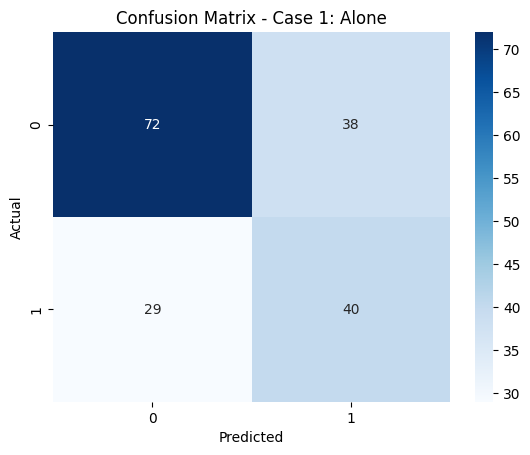

In [59]:
# Create confusion matrix for test predictions (Case 1)
cm1 = confusion_matrix(y1_test, y1_test_pred)

# Plot heatmap
sns.heatmap(cm1, annot=True, cmap='Blues')
plt.title('Confusion Matrix - Case 1: Alone')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

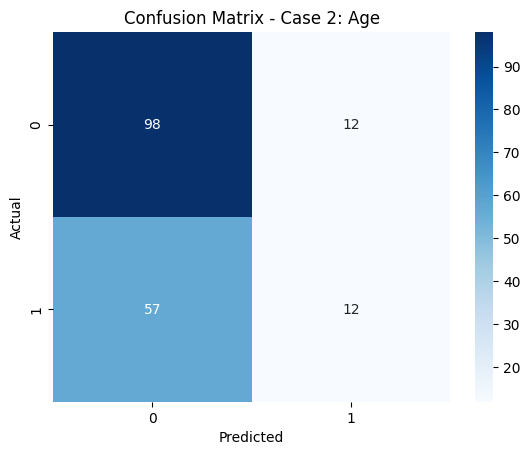

In [60]:
# Create confusion matrix for test predictions (Case 2)
cm2 = confusion_matrix(y2_test, y2_test_pred)

# Plot heatmap
sns.heatmap(cm2, annot=True, cmap='Blues')
plt.title('Confusion Matrix - Case 2: Age')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

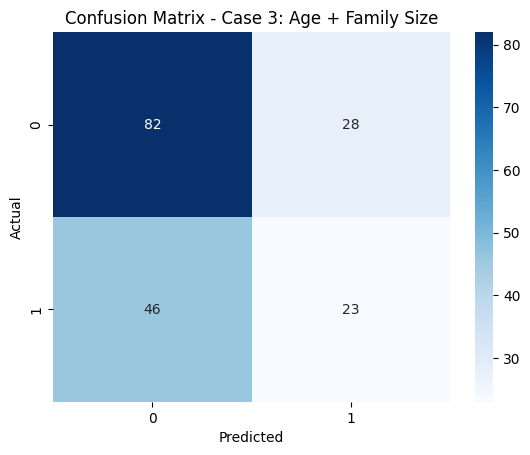

In [61]:
# Create confusion matrix for test predictions (Case 3)
cm3 = confusion_matrix(y3_test, y3_test_pred)

# Plot heatmap
sns.heatmap(cm3, annot=True, cmap='Blues')
plt.title('Confusion Matrix - Case 3: Age + Family Size')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### 4.5 Report Decision Tree Plot

Plot the DT model. We give the plotter the names of the features and the names of the categories for the target. 

#### Case 1

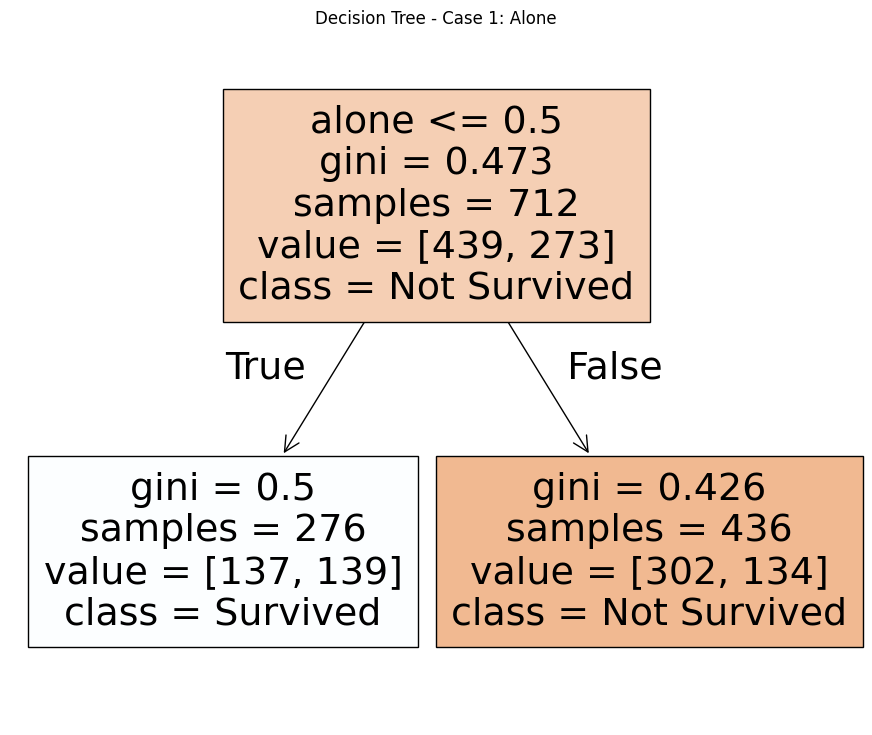

In [62]:
# Plot Decision Tree for Case 1
fig = plt.figure(figsize=(11, 9))
plot_tree(tree_model1,
          feature_names=X1.columns,
          class_names=['Not Survived', 'Survived'],
          filled=True)
plt.title("Decision Tree - Case 1: Alone")
plt.show()

# Save image
fig.savefig("tree_case1_alone.png")

#### Case 2

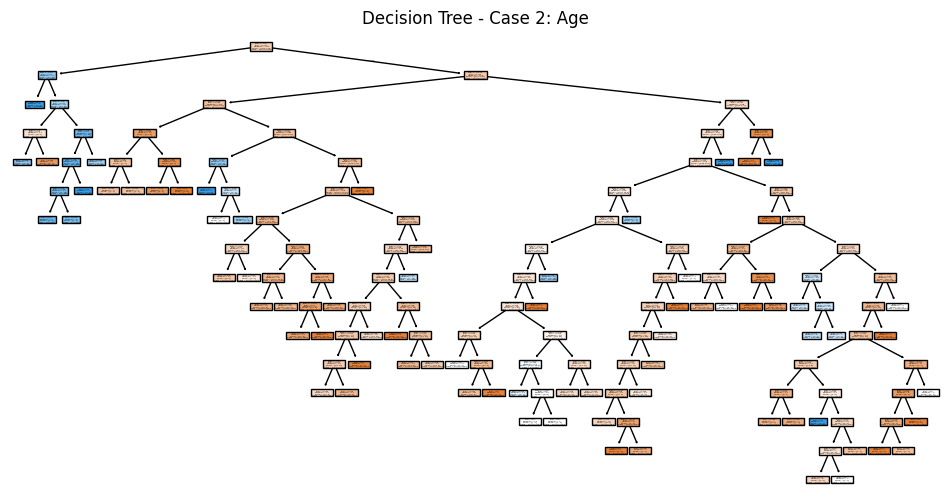

In [63]:
# Plot Decision Tree for Case 2
fig = plt.figure(figsize=(12, 6))
plot_tree(tree_model2,
          feature_names=X2.columns,
          class_names=['Not Survived', 'Survived'],
          filled=True)
plt.title("Decision Tree - Case 2: Age")
plt.show()

# Save image
fig.savefig("tree_case2_age.png")

#### Case 3

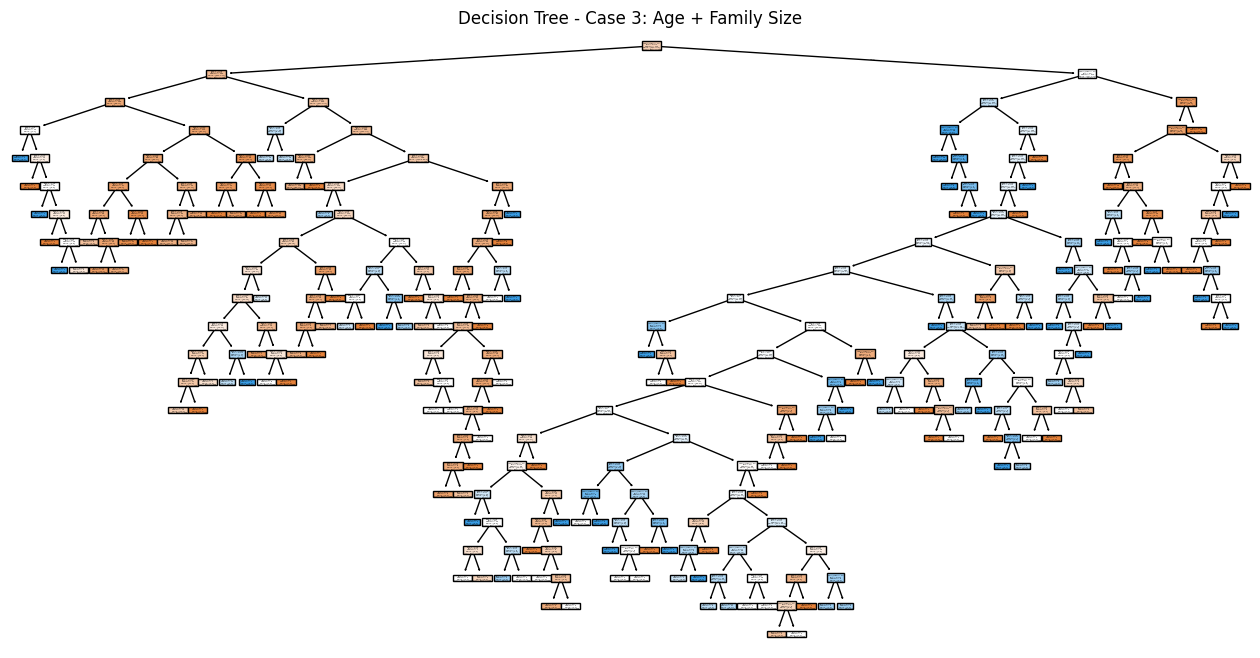

In [64]:
# Plot Decision Tree for Case 3
fig = plt.figure(figsize=(16, 8))
plot_tree(tree_model3,
          feature_names=X3.columns,
          class_names=['Not Survived', 'Survived'],
          filled=True)
plt.title("Decision Tree - Case 3: Age + Family Size")
plt.show()

# Save image
fig.savefig("tree_case3_age_family.png")

### Reflection 4:

**How well did the different cases perform?**

- **Case 1 (alone)**: Best generalization with minimal overfitting (62% → 63%)
- **Case 2 (age)**: Moderate performance with some overfitting (68% → 61%)
- **Case 3 (age + family_size)**: Highest training accuracy but worst generalization (77% → 59%)

**Are there any surprising results?**

**Yes, a few unexpected findings:**

1. **More Features did not equal Better Performance**: Case 3 with two features performed worse on test data (59%) than Case 1 with just one feature (63%). This demonstrates the curse of dimensionality and overfitting with small datasets.

2. **Age Alone Struggles**: Case 2 (age only) had surprisingly poor recall for survivors (0.17), meaning it missed 83% of actual survivors. The model became too conservative, predicting "not survived" for most passengers.

3. **Overfitting Pattern**: Training accuracy increased with more features (62% → 68% → 77%), but test accuracy decreased (63% → 61% → 59%), making for a classic overfitting behavior.

**Which inputs worked better?**

**Case 1 (alone) - 63% test accuracy**
- **Simplicity**: Binary feature reduces model complexity
- **Strong Signal**: Clear survival difference (50.6% with family vs 30.4% alone)

## Section 5. Compare Alternative Models (SVC, NN)

In a Support Vector Machine, the kernel function defines how the algorithm transforms data to find a hyperplane that separates the classes. If the data is not linearly separable, changing the kernel can help the model find a better decision boundary.

SVC Kernel: Common Types

    RBF (Radial Basis Function) – Most commonly used; handles non-linear data well (default)
    Linear – Best for linearly separable data (straight line separation)
    Polynomial – Useful when the data follows a curved pattern
    Sigmoid – Similar to a neural network activation function; less common

Commenting the options in and out in the code can be helpful. The analyst decides which to use based on their understanding of the results. 

In [65]:
# RBF Kernel (default) - same as calling SVC()
svc_model = SVC(kernel='rbf')
svc_model.fit(X1_train, y1_train)

# Linear Kernel
# svc_model = SVC(kernel='linear')
# svc_model.fit(X1_train, y1_train)

# Polynomial Kernel (e.g., with degree=3)
# svc_model = SVC(kernel='poly', degree=3)
# svc_model.fit(X1_train, y1_train)

# Sigmoid Kernel
# svc_model = SVC(kernel='sigmoid')
# svc_model.fit(X1_train, y1_train)

,C,1.0
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


SVC Kernel: How to Choose

    Start with linear if you suspect the data is linearly separable.
    Use RBF if the data is complex or you aren’t sure.
    Try polynomial if the data seems to follow a curved boundary.
    Use sigmoid for experiments (rarely the best choice).

SVC Kernel: Common Issues and Techniques

    If the model takes too long to train, reduce the degree for polynomial kernels.
    If support_vectors_ gives an error, the data may not be separable with the current kernel. Try switching to RBF or adjusting the C (regularization) value.
    If the model misclassifies many points, then increase/decrease gamma or C.

Your process is valuable - record the work you do and the temporary results in your reflections and insights. To show your skills, show and tell us about your analysis process. Professional communication is key.

### 5.1 Train and Evaluate Model (SVC)

First, train an SVC model using the default kernel. 

Case 1

In [66]:
# CASE 1: SVC using 'alone'
svc_model1 = SVC()
svc_model1.fit(X1_train, y1_train)
y1_svc_pred = svc_model1.predict(X1_test)
print("Results for SVC on test data (Case 1 - alone):")
print(classification_report(y1_test, y1_svc_pred))

Results for SVC on test data (Case 1 - alone):
              precision    recall  f1-score   support

           0       0.71      0.65      0.68       110
           1       0.51      0.58      0.54        69

    accuracy                           0.63       179
   macro avg       0.61      0.62      0.61       179
weighted avg       0.64      0.63      0.63       179



Case 2

In [67]:
# CASE 2: SVC using 'age'
svc_model2 = SVC()
svc_model2.fit(X2_train, y2_train)
y2_svc_pred = svc_model2.predict(X2_test)
print("Results for SVC on test data (Case 2 - age):")
print(classification_report(y2_test, y2_svc_pred))

Results for SVC on test data (Case 2 - age):
              precision    recall  f1-score   support

           0       0.63      0.98      0.77       110
           1       0.71      0.07      0.13        69

    accuracy                           0.63       179
   macro avg       0.67      0.53      0.45       179
weighted avg       0.66      0.63      0.52       179



Case 3

In [68]:
# CASE 3: SVC using 'age' and 'family_size'
svc_model3 = SVC()
svc_model3.fit(X3_train, y3_train)
y3_svc_pred = svc_model3.predict(X3_test)
print("Results for SVC on test data (Case 3 - age + family_size):")
print(classification_report(y3_test, y3_svc_pred))

Results for SVC on test data (Case 3 - age + family_size):
              precision    recall  f1-score   support

           0       0.63      0.98      0.77       110
           1       0.71      0.07      0.13        69

    accuracy                           0.63       179
   macro avg       0.67      0.53      0.45       179
weighted avg       0.66      0.63      0.52       179



### 5.2 Visualize Support Vectors (1D Case 1 and 2D Case 3)
We can create scatter plots to visualize support vectors. This helps understand how the SVM model separates the data. We'll use Case 1 first - but since it only has one dimension, it's kind of boring. Try to do so for Case 2 as well, but it is also only one input, and one case. Then, we'll do Case 3. Since Case 3 has two inputs, the plot has two dimensions, and our division will hopefully show a two dimensional division (like a line or margin). 
To visualize support vectors, we follow a 3 step process. 

Step 1) Split the data into two groups:

    Survived – Passengers who survived the Titanic sinking (value = 1).
    Not Survived – Passengers who did not survive (value = 0).

Step 2) Plot each category using different shapes and colors:

    Yellow squares ('s') for survived passengers
    Cyan triangles ('^') for non-survived passengers

Step 3) Overlay the support vectors — the critical data points used to define the decision boundary — with black plus signs.

    Black pluses ('+') will represent the support vectors.
    Since the support vectors are plotted last, they appear on top of the data points and are not obscured.


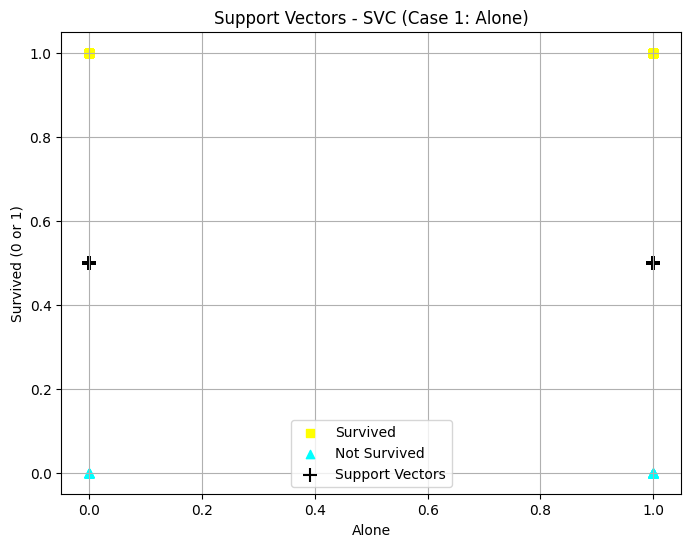

In [69]:
# Visualize support vectors for Case 1 (feature = 'alone')

# Create groups based on survival
survived_alone = X1_test.loc[y1_test == 1, 'alone']
not_survived_alone = X1_test.loc[y1_test == 0, 'alone']

# Create scatter plot for survived and not survived
plt.figure(figsize=(8, 6))

plt.scatter(survived_alone, y1_test.loc[y1_test == 1], c='yellow', marker='s', label='Survived')
plt.scatter(not_survived_alone, y1_test.loc[y1_test == 0], c='cyan', marker='^', label='Not Survived')

# Overlay support vectors
# Check if the model has support_vectors_ (it may not if it failed to converge)
if hasattr(svc_model1, 'support_vectors_'):
    # Get the X-values of the support vectors (only one feature in Case 1
    support_x = svc_model1.support_vectors_[:, 0]  # First feature (alone)
    # Plot them using a fixed Y-value (0.5) to place them between classes visually
    # We use a larger size (s=100) and a plus symbol to make them stand out
    plt.scatter(support_x, [0.5] * len(support_x), c='black', marker='+', s=100, label='Support Vectors')

# Add labels and legend
plt.xlabel('Alone')
plt.ylabel('Survived (0 or 1)')
plt.title('Support Vectors - SVC (Case 1: Alone)')
plt.legend()
plt.grid(True)
plt.show()

Case 3. Two Inputs, Two Dimensional Scatter Plot

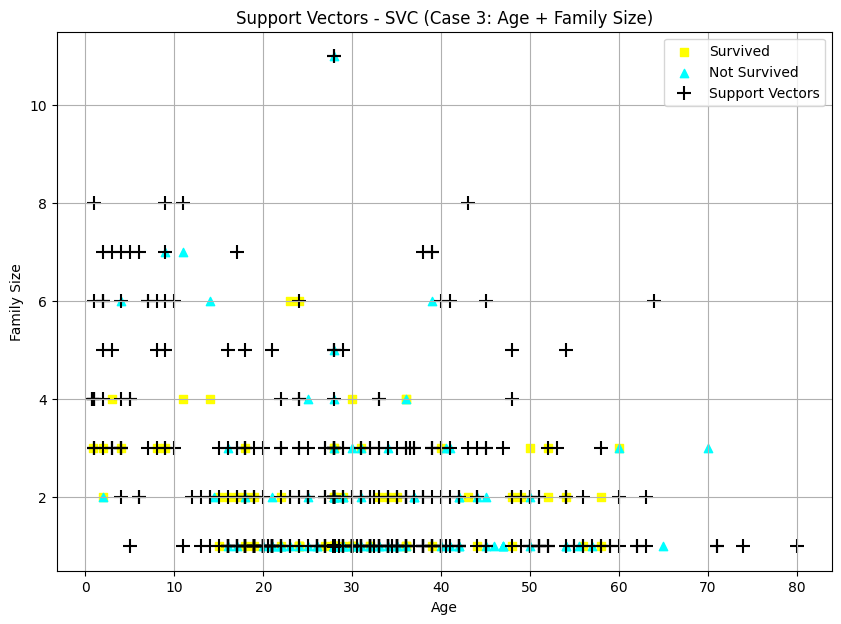

In [70]:
# Visualize support vectors for Case 3 (features = 'age', 'family_size') - more interesting (two dimensional)

# Create groups based on survival
survived = X3_test[y3_test == 1]
not_survived = X3_test[y3_test == 0]

# Create scatter plot
plt.figure(figsize=(10, 7))

# Plot survived (yellow squares)
plt.scatter(survived['age'], survived['family_size'],
            c='yellow', marker='s', label='Survived')

# Plot not survived (cyan triangles)
plt.scatter(not_survived['age'], not_survived['family_size'],
            c='cyan', marker='^', label='Not Survived')

# Overlay support vectors
if hasattr(svc_model3, 'support_vectors_'):
    support_vectors = svc_model3.support_vectors_
    plt.scatter(support_vectors[:, 0], support_vectors[:, 1],
                c='black', marker='+', s=100, label='Support Vectors')

# Add labels, title, and legend
plt.xlabel('Age')
plt.ylabel('Family Size')
plt.title('Support Vectors - SVC (Case 3: Age + Family Size)')
plt.legend()
plt.grid(True)
plt.show()

NOTE:  When trying to visualize additional cases, the support_vectors_ attribute might give an error if the model didn't converge or if the problem is not linearly separable. To try to get it to converge, try adjusting the kernel or tuning hyperparameters (more on this below). Adjust the charting accordingly. 

NOTE: 

Why [0.5] * len(support_x)?
In Case 1, we only used one input feature (alone). The model is working in one dimension - it’s trying to draw a boundary along a single dimension. To visualize support vectors on a 2D plot (which is how we’re drawing our scatter), we need to:

Use the support_vectors_[:, 0] as the X-values (the only feature, alone)

Place them at an arbitrary Y-position (like 0.5) so they appear in the middle of our target space (0 or 1)

This is not "real" data on the Y-axis for the support vectors — it’s just a visual trick to put the plus signs roughly between the survived (1) and not survived (0) points on the chart. That way, we can clearly see which points the model used to define the decision boundary.

### 5.3 Train and Evaluate Model (Neural Network on Case 3)

Now, we'll train a Neural Network (Multi-Layer Perceptron) classifier using age and family_size as input features. This is the most informative case and gives us two continuous features to help the network learn patterns and relationships.

We'll use:

- An input (visible) layer  - with age and family size - that's two input neurons visible to us and the model.
- Three hidden layers with decreasing sizes (50, 25, 10) - These are layers of neurons the model creates to learn patterns. Each neuron receives input from all neurons in the previouslayer, applies a function, and passes the result on.
- One output layer - a single neuron with our probability of survival (yes / no for a binary classification). 
- The lbgfs solver which works better with small data sets like the Titanic
- A higher number of maximum iterations (max_iter) to help it converge.
- A fixed random_state so the work is reproducible and doesn't change each time we run it. 



Train NN on Case 3

In [71]:
# Train NN for Case 3 (age + family_size)
nn_model3 = MLPClassifier(
    hidden_layer_sizes=(50, 25, 10),
    solver='lbfgs',
    max_iter=1000,
    random_state=42
)

nn_model3.fit(X3_train, y3_train)

,hidden_layer_sizes,"(50, ...)"
,activation,'relu'
,solver,'lbfgs'
,alpha,0.0001
,batch_size,'auto'
,learning_rate,'constant'
,learning_rate_init,0.001
,power_t,0.5
,max_iter,1000
,shuffle,True
,random_state,42


Predict and evaluate Neural Network model:

In [72]:
# Predict on test data (Case 3)
y3_nn_pred = nn_model3.predict(X3_test)

# Print classification report
print("Results for Neural Network on test data (Case 3 - age + family_size):")
print(classification_report(y3_test, y3_nn_pred))

Results for Neural Network on test data (Case 3 - age + family_size):
              precision    recall  f1-score   support

           0       0.69      0.83      0.75       110
           1       0.60      0.41      0.48        69

    accuracy                           0.66       179
   macro avg       0.64      0.62      0.62       179
weighted avg       0.65      0.66      0.65       179



Plot confusion matrix:

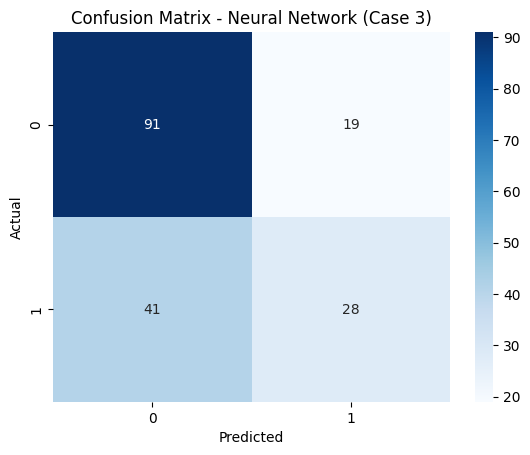

In [73]:
# Create confusion matrix
cm_nn3 = confusion_matrix(y3_test, y3_nn_pred)

# Plot heatmap
sns.heatmap(cm_nn3, annot=True, cmap='Blues')
plt.title('Confusion Matrix - Neural Network (Case 3)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### 5.4 Visualize (Neural Network on Case 3)

We can visualize the learned decision boundary of the neural network - the way it separates the two target classes into survived and not-survived. Since we have two features (age and family_size), we can create a 2D plot showing how the model predicts across different combinations of those features.

This is a great way to visualize decision boundaries — regions where the model switches from predicting not-survived to survived. 

In [74]:
# Get the range of our two features - use padding to enhance appearance

padding = 1
x_min, x_max = X3['age'].min() - padding, X3['age'].max() + padding
y_min, y_max = X3['family_size'].min() - padding, X3['family_size'].max() + padding

In [75]:
# Create a meshgrid (all combinations of age and family_size)

# A grid of values covering the entire input space
# np.linspace(start, stop, num) generates evenly spaced values (like a ruler)
# Here, we create 500 points between min and max for each axis
# np.meshgrid creates a coordinate grid from the two arrays

xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
                                    np.linspace(y_min, y_max, 500))

In [76]:
# Flatten the grid arrays and prepare them for prediction
# np.c_ stacks the flattened xx and yy into coordinate pairs
# .ravel() flattens a 2D array into 1D (required by the model for prediction)

Z = nn_model3.predict(np.c_[xx.ravel(), yy.ravel()])

# Reshape the predicted results to match the original 2D grid shape
Z = Z.reshape(xx.shape)

c:\Repos\applied-ml-dineshguru\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


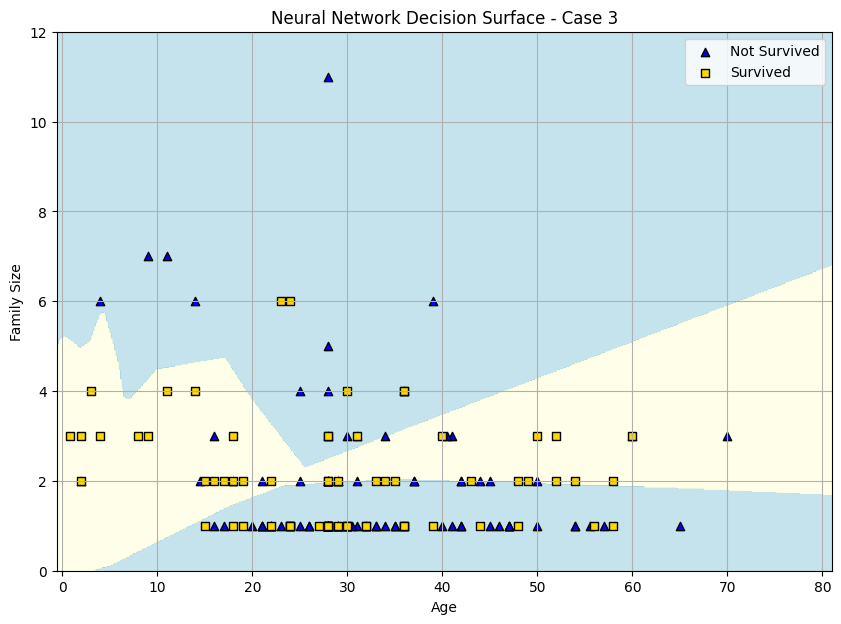

In [77]:
# Plot the decision surface (background) showing predicted survival zones

 # Blue for 0, yellow for 1 - change this up as you like
plt.figure(figsize=(10, 7))
cmap_background = ListedColormap(['lightblue', 'lightyellow'])

plt.contourf(xx, yy, Z, cmap=cmap_background, alpha=0.7)

# Overlay the actual test data points for visual comparison
# Plot passengers who did NOT survive (0) as blue triangles
plt.scatter(X3_test['age'][y3_test == 0],
            X3_test['family_size'][y3_test == 0],
            c='blue', marker='^', edgecolor='k', label='Not Survived')

# Plot passengers who DID survive (1) as gold squares
plt.scatter(X3_test['age'][y3_test == 1],
            X3_test['family_size'][y3_test == 1],
            c='gold', marker='s', edgecolor='k', label='Survived')

# Add axis labels, title, legend, and grid
plt.xlabel('Age')
plt.ylabel('Family Size')
plt.title('Neural Network Decision Surface - Case 3')
plt.legend()
plt.grid(True)
plt.show()



### Reflection 5:

**How well did each of these new models/cases perform?**

- **Neural Network was the best** with 66% accuracy on Case 3 (age + family_size)
- **Decision Tree and SVM tied** at 63% accuracy for Case 1 (alone)
- **SVM struggles** with survivor detection for all casesodels

**Are there any surprising results or insights?**

**Yes, a few surprises:**

   - Simple models (Decision Tree, SVM) performed **worse** with more features
   - Neural Network performed **better** with more features

**Why might one model outperform the others?**

**Why Neural Networks excelled:**
- **Non-linear Pattern Recognition**: Can capture complex interactions between age and family_size
- **Appropriate Architecture**: 3 hidden layers (50, 25, 10) provided enough complexity without overfitting

**Decision Tree & SVM (63% accuracy) for Simple Features:**
- **Binary Decision Boundary**: "Alone" feature creates clear, linear separation
- **Low Dimensional Space**: Both models excel with single, well-defined features

## Section 6. Final Thoughts & Insights

### 1. Summary of Findings Table

| Model Type | Case | Features Used | Accuracy | Precision | Recall | F1-Score | Notes |
|------------|------|---------------|----------|-----------------|--------------|----------------|------------------|
| **Decision Tree** | 1 | alone | **63%** | 61% | 62% | 61% | Best generalization, minimal overfitting |
| | 2 | age | 61% | 57% | 53% | 50% | Poor survivor recall (17%) |
| | 3 | age + family_size | 59% | 55% | 54% | 54% | Significant overfitting evident |
| **SVM (RBF)** | 1 | alone | **63%** | 61% | 62% | 61% | Matches Decision Tree performance |
| | 2 | age | 63% | 67% | 53% | 45% | Terrible survivor recall (7%!) |
| | 3 | age + family_size | 63% | 67% | 53% | 45% | No improvement from added features |
| **Neural Network** | 3 | age + family_size | **66%** | 64% | 62% | 63% | Highest accuracy achieved |

#### **Performance Rank:**
   - **Neural Network (Case 3)**: 66% accuracy - Best overall performance
   - **Decision Tree & SVM (Case 1)**: 63% accuracy - Tied for simple features  
   - **Decision Tree (Case 2)**: 61% accuracy - Moderate performance

### 2. Challenges Faced

   - Identified that simpler models work better with fewer, well-chosen features
   - The model became overly conservative, missing 93% of actual survivors
   - Titanic dataset (891 passengers) limited model complexity

### 3. Next Steps for Further Insights

   **Additional Features to Explore**
   - **Gender**: Likely the strongest predictor ("women and children first")
   - **Passenger Class**: Socioeconomic status affects survival

Use hyperparameter tuning for existing models and adding the most predictive features (gender, class) before exploring more complex algorithms. 